# Figure 2: Do LLMs replicate the sparsity effect?

In [48]:
import yaml
import random
import json
import pandas as pd
import seaborn as sns
import numpy as np
import typing
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib
from matplotlib import pyplot as plt
from functools import reduce

# import kendall_w.kendall_w as kw
import scipy.stats
from tqdm.auto import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
import math
import statsmodels.api as sm

# import seaborn_image as isns

sns.set_theme()

In [4]:
def ECDF_transform(arr: np.ndarray):
    return ECDF(arr)(arr)

### Data-loading function

In [18]:
obs = (
    pd.read_pickle("./simulate-comb-A-N/matrix.pkl")[:1_000, :1_000]
    .todense()
    .reshape(-1)
)

In [29]:
def get_results(
    model="gpt2_xl",
    study="composlang",
    paradigm="logprobs",
    basedir=Path("./llm-results/"),
):
    [resultsdir] = (basedir / study).glob("benchmark-cfg=*")
    results = list(resultsdir.glob(f"eval={paradigm}*/model={model}/results.csv"))
    results = [pd.read_csv(r, index_col=0) for r in results]
    if len(results) == 2:
        results = pd.merge(*results)
    elif len(results) == 1:
        results = results[0]
    else:
        raise ValueError(f"Found {len(results)} results")

    results = results[(results.arank >= 0) & (results.nrank >= 0)]

    if paradigm == "logprobs":
        levels = ("metadata", model)
        model_columns = ["logp_A", "logp_N", "logp_N_A"]
        metadata_columns = results.columns.difference(model_columns)

        mii = pd.MultiIndex.from_tuples(
            tuples=[("metadata", c) for c in results.columns if c in metadata_columns]
            + [(model, c) for c in results.columns if c in model_columns],
            # names=levels,
        )
        results.columns = mii
        # results["metadata", "model"] = model

        col = "logp_N_A"
        ecdf = ECDF_transform(results[model, col])
        results[model, f"ecdf_{col}"] = ecdf

        results[model, "pmi"] = (
            results[model, "logp_N_A"] - results[model, "logp_N"]
        ) / math.log(2)

        results["metadata", "observed"] = obs

    else:
        raise NotImplementedError(f"paradigm={paradigm}!=logprobs")

    return results.sort_index(axis=1)

In [6]:
models = ["gpt2_xl", "phi_2", "mpt_7b", "mpt_7b_chat"]

In [30]:
gpt2xl = get_results(model="gpt2_xl")
phi2 = get_results(model="phi_2")
mpt7b = get_results(model="mpt_7b")
mpt7bchat = get_results(model="mpt_7b_chat")

In [31]:
mpt7bchat

metadata                                  mpt_7b_chat             \
          adjective arank      noun nrank observed ecdf_logp_N_A     logp_A   
20027         other     0    people     0    20619      0.999653 -11.875000   
20028         other     0      time     1     1301      0.958600 -11.875000   
20029         other     0     years     2      291      0.550016 -11.875000   
20030         other     0      year     3      343      0.470481 -11.875000   
20031         other     0       way     4     7711      0.626445 -11.875000   
...             ...   ...       ...   ...      ...           ...        ...   
1020022  unfamiliar   999      beer   995        0      0.663396 -16.835938   
1020023  unfamiliar   999    option   996        0      0.761914 -16.835938   
1020024  unfamiliar   999       key   997        0      0.881969 -16.835938   
1020025  unfamiliar   999  exchange   998        0      0.816887 -16.835938   
1020026  unfamiliar   999     facts   999        0      0.881969 -16.835938   

                                       
           logp_N  logp_N_A       pmi  
20027    -7.40625  -2.03125  7.754486  
20028   -11.37500  -7.28125  5.906033  
20029   -11.37500 -11.56250 -0.270505  
20030   -12.62500 -12.06250  0.811516  
20031   -12.62500 -11.06250  2.254211  
...           ...       ...       ...  
1020022 -14.09375 -10.81250  4.733843  
1020023 -12.62500 -10.06250  3.696906  
1020024 -12.37500  -8.81250  5.139601  
1020025 -13.12500  -9.56250  5.139601  
1020026 -14.62500  -8.81250  8.385665  

[1000000 rows x 10 columns]

In [196]:
y = mpt7bchat["metadata", "observed"].tail(10**6 - 1_000)
x = mpt7bchat["mpt_7b_chat", "logp_N_A"].tail(10**6 - 1_000)
model = sm.OLS(y, sm.add_constant(x))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     ('metadata', 'observed')   R-squared:                       0.009
Model:                                  OLS   Adj. R-squared:                  0.009
Method:                       Least Squares   F-statistic:                     9203.
Date:                      Fri, 19 Jan 2024   Prob (F-statistic):               0.00
Time:                              03:03:46   Log-Likelihood:            -6.5994e+06
No. Observations:                    999000   AIC:                         1.320e+07
Df Residuals:                        998998   BIC:                         1.320e+07
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          88.1715      0.820    107.490      0.000      86.564      89.779
('mpt_7b_chat', 'logp_N_A')     6.4908      0.068     95.931      0.000       6.358       6.623
==============================================================================
Omnibus:                  4425125.907   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   46633939705223.461
Skew:                         142.299   Prob(JB):                         0.00
Kurtosis:                   33473.194   Cond. No.                         55.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [197]:
fit.params, fit.rsquared

(const                      88.171512
 (mpt_7b_chat, logp_N_A)     6.490798
 dtype: float64,
 0.009127887160832349)

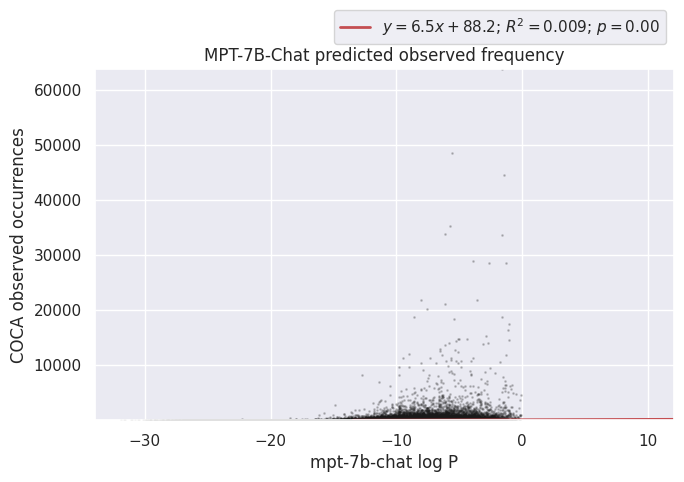

In [198]:
f, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x, y, alpha=0.2, s=1, c="k")
# ax.set_yscale("log")
# ax.set_yscale("log")
# extract intercept b and slope m
b, m = fit.params
# plot y = m*x + b
ax.axline(
    xy1=(0, b),
    xy2=(10, 10 * m + b),
    color="r",
    linewidth=2,
    linestyle="-",
    # slope=m,
    label=f"$y = {m:.1f}x {b:+.1f}$; $R^2={fit.rsquared:.3f}$; $p={fit.pvalues[1]:.2f}$",
)
# ax.set_xlim(min(x), max(x))
ax.set_ylim(1, max(y))
ax.legend(loc="lower right", bbox_to_anchor=(1, 1.05))
ax.set_title("MPT-7B-Chat predicted observed frequency")
ax.set_xlabel("mpt-7b-chat log P")
ax.set_ylabel("COCA observed occurrences")

plt.tight_layout()
plt.show()

In [56]:
pred = m.predict(mpt7bchat["mpt_7b_chat", "logp_N_A"])

TypeError: not all arguments converted during string formatting

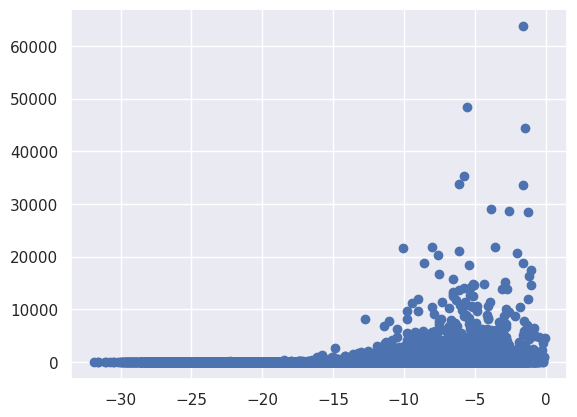

In [70]:
sm.graphics.plot_fit(m, 0)

KeyboardInterrupt: 

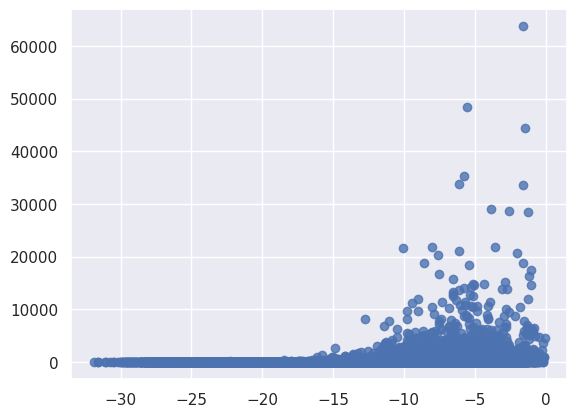

In [69]:
# ax.scatter(mpt7bchat['mpt_7b_chat', "logp_N_A"], mpt7bchat['metadata', 'observed'], alpha=0.1)
ax = sns.scatterplot(
    x=mpt7bchat["mpt_7b_chat", "logp_N_A"],
    y=mpt7bchat["metadata", "observed"],
    # edgecolor=None,
    # s=3,
    # alpha=0.1,
)

In [52]:
m

AttributeError: 'OLSResults' object has no attribute 'plot'

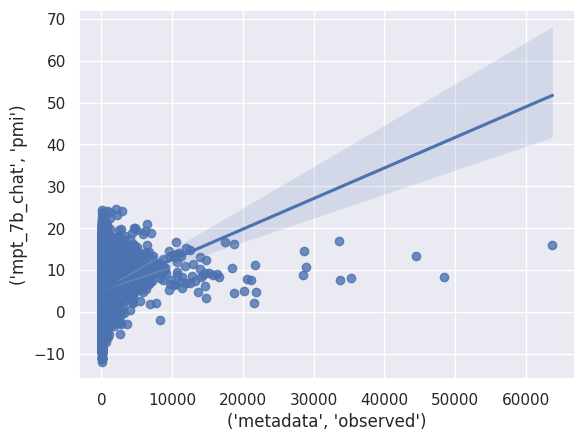

In [47]:
view = mpt7bchat.sort_values(by=("metadata", "observed"), ascending=False).head(10_000)
sns.regplot(
    x=view[("metadata", "observed")],
    y=view[("mpt_7b_chat", "pmi")],
    # edgecolor=None,
    # s=5,
)
plt.show()

In [14]:
def construct_mat(df, col="pmi"):
    model = df.columns[-1][0]
    mat = np.zeros((1000, 1000))
    for i, row in tqdm(df.iterrows(), total=len(df)):
        mat[row.loc[("metadata", "arank")], row.loc[("metadata", "nrank")]] = row.loc[
            (model, "pmi")
        ]
    return mat

In [7]:
mpt7bchat.sort_values(by="logp_N_A", ascending=False)

,adjective,noun,arank,nrank,logp_A,logp_N,logp_N_A
862243,affirmative,action,842,216,-14.644531,-13.8750,-0.045410
973159,crude,oil,953,132,-14.968750,-12.6250,-0.099121
672196,outer,space,652,169,-15.125000,-11.1250,-0.121582
173097,nuclear,war,153,70,-11.625000,-10.1250,-0.154297
231186,negative,interest,211,159,-12.375000,-11.6250,-0.158203
...,...,...,...,...,...,...,...
522778,universal,toolong,502,751,-12.375000,-24.1875,-31.062500
361778,unable,toolong,341,751,-12.500000,-24.1875,-31.125000
247778,mental,toolong,227,751,-13.375000,-24.1875,-31.562500
236778,worst,toolong,216,751,-15.851562,-24.1875,-31.625000


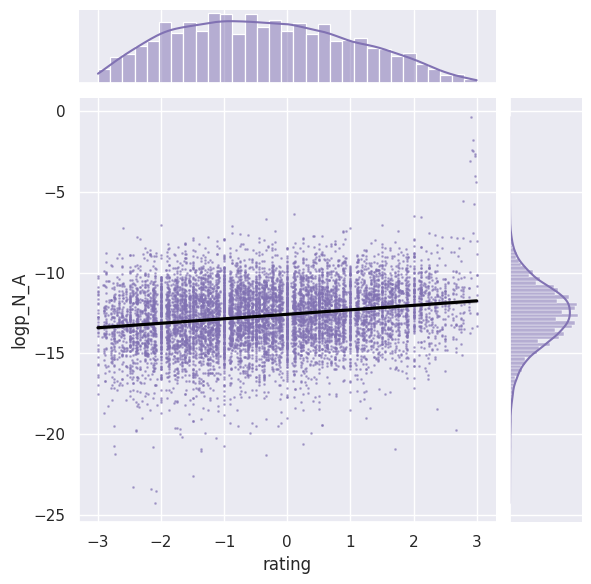

In [128]:
sns.jointplot(
    data=gptlogp,
    y="logp_N_A",
    x="rating",
    kind="reg",
    scatter_kws={"s": 1, "alpha": 0.5},
    line_kws={"color": "black"},
    color="m",
    ci=99,
    # hue="trial_type",
    # edgecolor=None,
    # s=1,
)

In [98]:
gptlogpall = get_results(study="composlang", model="gpt2_xl", paradigm="logprobs")
gptlogpall = gptlogpall[(gptlogpall["arank"] >= 0) & (gptlogpall["nrank"] >= 0)]

In [99]:
phi2logpall = get_results(study="composlang", model="phi_2", paradigm="logprobs")
phi2logpall = phi2logpall[(phi2logpall["arank"] >= 0) & (phi2logpall["nrank"] >= 0)]

<AxesSubplot:xlabel='nrank', ylabel='arank'>

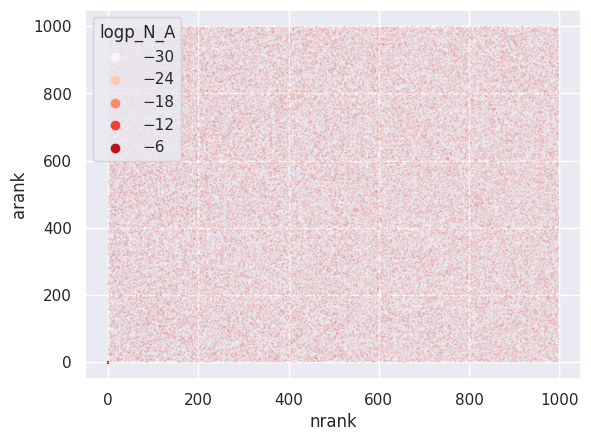

In [8]:
sns.scatterplot(
    data=mpt7bchat.sample(100_000),
    x="nrank",
    y="arank",
    hue="logp_N_A",
    edgecolor=None,
    s=1,
    alpha=0.1,
    palette="Reds",
)

In [100]:
view = pd.merge(gptlogpall, phi2logpall, on=["id"])

In [103]:
view.sample(10)

,adjective_x,noun_x,arank_x,nrank_x,logp_N_A_x,adjective_y,noun_y,arank_y,nrank_y,logp_N_A_y
id,,,,,,,,,,
643637,harsh,streets,643,637,-11.1875,harsh,streets,643,637,-11.912045
537704,behavioral,hell,537,704,-10.3750,behavioral,hell,537,704,-13.732407
551745,lowest,truck,551,745,-11.8125,lowest,truck,551,745,-10.664518
566587,islamic,investigation,566,587,-11.8125,islamic,investigation,566,587,-12.811707
508967,joint,authorities,508,967,-9.7500,joint,authorities,508,967,-9.600072
42049,whole,side,42,49,-9.6875,whole,side,42,49,-8.653444
750998,unprecedented,exchange,750,998,-9.5000,unprecedented,exchange,750,998,-10.237356
2183,new,summer,2,183,-9.1875,new,summer,2,183,-11.083316
691020,tribal,work,691,20,-8.9375,tribal,work,691,20,-8.869001


<AxesSubplot:xlabel='logp_N_A_x', ylabel='logp_N_A_y'>

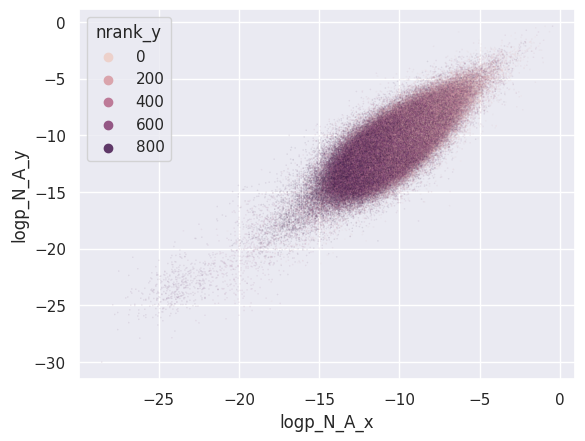

In [106]:
sns.scatterplot(
    data=view.sample(500_000),
    x="logp_N_A_x",
    y="logp_N_A_y",
    hue="nrank_y",
    edgecolor=None,
    s=1,
    alpha=0.1,
    # palette="Reds",
)

<AxesSubplot:xlabel='logp_N_A', ylabel='logp_N'>

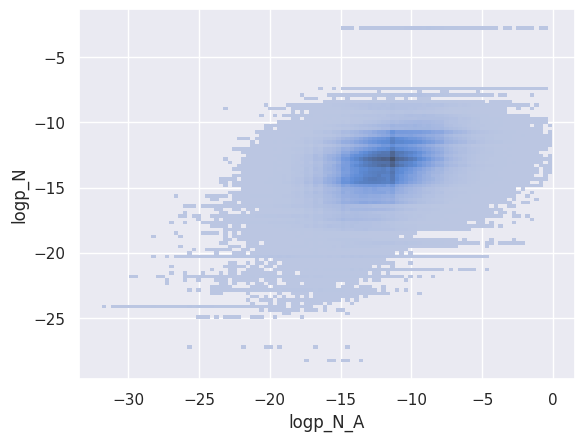

In [19]:
sns.histplot(
    data=mpt7bchat,
    x="logp_N_A",
    y="logp_N",
    # hue="trial_type",
    # edgecolor=None,
    # s=1,
    # alpha=0.1,
    bins=100,
)

In [134]:
gptlogp.apply(lambda x: x["logp_N_A"] - x["logp_N"], axis=1)

0       2.5625
1       5.6875
2       3.1250
3       2.5000
4       3.3750
         ...  
9902    2.5625
9903    4.5000
9904    4.0625
9905    4.8125
9906    6.4375
Length: 9907, dtype: float64